# Assignment #3
## Topic: Political Reviews - 
Name: **Hoo Yee Torng** </br>
Matrix: **P101447**

## 1.0 IMPORT LIBRARY
Import all the library needed and download the 

In [1]:
import pandas as pd
import nltk
import time
import numpy as np
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 2.0 Load Dataset files to be processed
download following files and upload to the workspace
- [politic_issues_positive_reviews.csv](https://drive.google.com/drive/folders/1SBji6xGIjRWvhm41MKIquDML_d-qsvW9?usp=sharing)
- [politic_issues_negative_reviews.csv](https://drive.google.com/drive/folders/1SBji6xGIjRWvhm41MKIquDML_d-qsvW9?usp=sharing) <br/>

Create a combined master set of data with class **0 as Negative** review and **1 as Positive**

In [2]:
# READ FROM NEGATIVE REVIEW AND ASSIGN 0 AS CLASS VALUE
negative_df = pd.read_csv('politic_issues_negative_reviews.csv')
negative_df["label"] = 0
print(negative_df.shape)

# READ FROM POSITIVE REVIEW AND ASSIGN 1 AS CLASS VALUE
positive_df = pd.read_csv('politic_issues_positive_reviews.csv')
positive_df["label"] = 1
print(positive_df.shape)

# APPEND BOTH DATAFRAME AS 1
raw_df = positive_df.append(negative_df) 

# RENAME COLUMN
raw_df = raw_df.rename(columns={"Google Translate": "review"})
print(raw_df.shape)

raw_df.index = range(100)
raw_df['review'].apply(lambda x: len(x.split(' '))).sum()


(54, 2)
(46, 2)
(100, 2)


3522

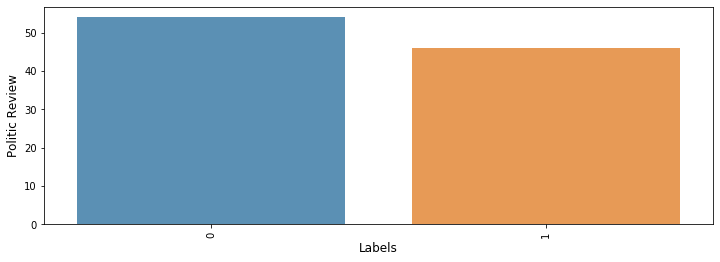

In [3]:
cnt_pro = raw_df['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Politic Review', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## 3.0 PRE-PROCESSING

In [0]:
def extract_words(setence):
  text = re.sub("[^a-zA-Z]", " ", setence)
  return(text.lower())

def clean_word(sentence):
  text = re.sub(r'\|\|\|', r' ', sentence) 
  text = re.sub(r'http\S+', r'<URL>', text)
  text = text.replace('x', '')
  return text

def remove_stopword(sentence):
    new_line = []
    word_tokens = nltk.word_tokenize(sentence)
    for w in word_tokens:
      if w not in stop_words:
        new_line.append(w)
    
    return (" ".join(new_line) + " ").strip()

def get_adjective_word(setence):
  words = []

  ## CHECK BY SPACY FIRST
  spacy_words = nlp(u''+setence+'')
  for token in spacy_words:
    if token.pos_ == 'ADJ':
      #print("SPACY: {}:{}".format(token.text, token.pos_))
      words.append(token.text)

  ## CHECK BY NLTK
  nltk_words = nltk.word_tokenize(setence)
  for stc in nltk_words:
    nltk_token = nltk.pos_tag(nltk.word_tokenize(stc))
    if nltk_token[0][1] == 'JJ' and nltk_token[0][0] not in words:
      #print("NTLK : {}:{}".format(nltk_token[0][0], nltk_token[0][1]))
      words.append(nltk_token[0][0])
    
  return (" ".join(words) + " ").strip()

def text_processing(objdf):
  for index, row in objdf.iterrows():
    selected_review = row['review'].strip()
    #print("--")
    #print(selected_review)
    selected_review = extract_words(selected_review)
    selected_review = clean_word(selected_review)
    selected_review = remove_stopword(selected_review)
    #selected_review = get_adjective_word(selected_review)
    objdf.loc[index, "review"] = selected_review 
    #print(objdf.loc[index, "review"])
  return objdf

df = text_processing(raw_df)

In [0]:
def show_percentage(x):
  return "{0:.2f}%".format(round(x, 2) * 100)

def run_ML(feature_name, xtrain, ytrain, xtest, ytest):

  print("-----------------------------------------------------------------------------")
  print("- " + feature_name)
  print("-----------------------------------------------------------------------------")

  clf_dict = {
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0),
    'MultinomialNB': MultinomialNB(),
    'ANN': MLPClassifier(solver='adam', hidden_layer_sizes=(35,15), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
    'SVN': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
    'LinearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
  }

  for name, clf in clf_dict.items():
    clf.fit(xtrain, ytrain) 
    pred = clf.predict(xtest)
    print("-- " + name)
    print('Testing accuracy: {}'.format(show_percentage(accuracy_score(ytest, pred))))
    print('Testing F1 score: {}'.format(show_percentage(f1_score(ytest, pred, average='macro'))))
    print('Testing Precision score: {}'.format(show_percentage(precision_score(ytest, pred, average='macro'))))
    print('Testing Recall score: {} \n'.format(show_percentage(recall_score(ytest, pred, average='macro'))))    

In [6]:
features = df['review'].values
classes = df['label'].values

sentences_train, sentences_test, yy_train, yy_test = train_test_split(features, classes, test_size=0.1, random_state=42, shuffle=True)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(sentences_train.shape[0]))
print('Number of rows in the test set: {}'.format(sentences_test.shape[0]))

Number of rows in the total set: 100
Number of rows in the training set: 90
Number of rows in the test set: 10


## 4.1 FEATURE-BOW

In [7]:
BOW = CountVectorizer()
BOW.fit(sentences_train)
XX_train = BOW.transform(sentences_train)
XX_test  = BOW.transform(sentences_test)
run_ML("BOW", XX_train, yy_train, XX_test, yy_test)

-----------------------------------------------------------------------------
- BOW
-----------------------------------------------------------------------------
-- GradientBoostingClassifier
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 

-- RandomForestClassifier
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- MultinomialNB
Testing accuracy: 60.00%
Testing F1 score: 58.00%
Testing Precision score: 75.00%
Testing Recall score: 67.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- ANN
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- SVN
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- LinearSVC
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- LogisticRegression
Testing accuracy: 60.00%
Testing F1 score: 58.00%
Testing Precision score: 75.00%
Testing Recall score: 67.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.3 FEATURE-TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF = TfidfVectorizer()
TFIDF.fit_transform(sentences_train)
XXX_train = TFIDF.transform(sentences_train)
XXX_test  = TFIDF.transform(sentences_test)

run_ML("TF-IDF", XXX_train, yy_train, XXX_test, yy_test)

-----------------------------------------------------------------------------
- TF-IDF
-----------------------------------------------------------------------------
-- GradientBoostingClassifier
Testing accuracy: 50.00%
Testing F1 score: 49.00%
Testing Precision score: 55.00%
Testing Recall score: 54.00% 

-- RandomForestClassifier
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- MultinomialNB
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- ANN
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- SVN
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- LinearSVC
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- LogisticRegression
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### REPORT :<br>

DOC2VEC/LR:  <br>
DOC2VEC/SVM:
DOC2VEC/NB:

BOW/LR:<br>
BOW/SVM:<br>
BOW/NB:<br>

TFIDF/LR:<br>
TFIDF/SVM:<br>
TFIDF/NB:<br>

-------
What is the best classification model?


answer = TF-IDF with LR